In [63]:
import json
import requests
import flickrapi
import pandas as pd
from tqdm import tqdm
from vincenty import vincenty
import geopandas
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import time
import numpy as np
from sklearn import metrics


In [35]:
df = pd.read_csv('photoset.csv')
df.head()

,id,name,lat,lon,locality,neighbourhood,geometry
0,50966372106,Flowing,63.447933,26.673366,Pielavesi,Nousiala,POINT (26.673366 63.447933)
1,50965089143,Iisalmi,63.562122,27.188588,Iisalmi,Iisalmi,POINT (27.188588 63.562122)
2,50959607628,"Raholan Pyrkivä - Hyvinkään Ponteva, Miesten D...",61.508915,23.627547,Tampere,Tohloppi,POINT (23.627547 61.508915)
3,50959607383,"Raholan Pyrkivä - Hyvinkään Ponteva, Miesten D...",61.508915,23.627547,Tampere,Tohloppi,POINT (23.627547 61.508915)
4,50958988873,DJI_0987,61.105755,21.448102,Rauma,Sampaanala,POINT (21.448102 61.105755)


In [74]:
df.groupby(['lon','lat']).size().reset_index().rename(columns={0:'count'})

,lon,lat,count
0,21.448102,61.105755,54
1,21.474083,69.482066,54
2,21.476972,68.684638,54
3,21.513408,61.126868,54
4,21.556001,61.572327,54
...,...,...,...
140,28.312097,62.120786,54
141,28.401200,61.603702,54
142,28.551481,61.038155,54
143,28.590652,61.118366,54


In [36]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat))

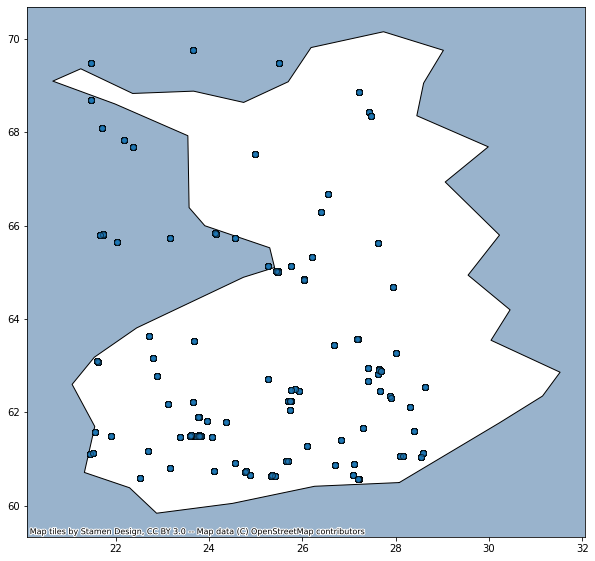

In [46]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'Finland'].plot(figsize=(10, 10),
    color='white', edgecolor='black')
ctx.add_basemap(ax, zoom=2)
gdf.plot(ax=ax, alpha=0.5, edgecolor='k')

plt.show()

In [56]:
coords = df[["lat", "lon"]].values

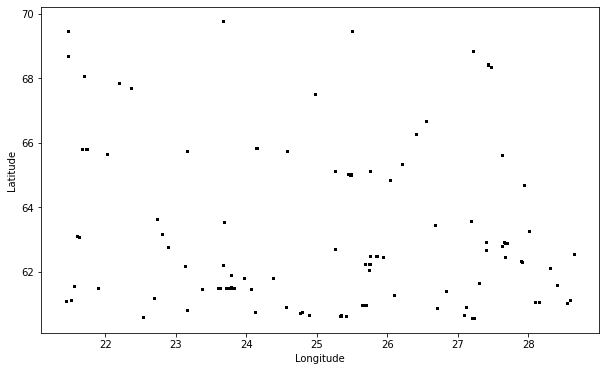

In [72]:
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [64]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 1.5 / kms_per_radian

start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))


Clustered 9,342 points down to 93 clusters, for 99.0% compression in 0.09 seconds
Silhouette coefficient: 0.920


In [65]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [66]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [67]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

,lon,lat
88,27.402110,62.677688
89,28.551481,61.038155
90,23.963861,61.814305
91,27.912644,62.305661
92,23.598117,61.493721


In [69]:
rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['lon']==row['lon'])].iloc[0], axis=1)
rs.to_csv('res_clust.csv', encoding='utf-8')
rs.tail()

,id,name,lat,lon,locality,neighbourhood,geometry
88,50440465043,Kutunjärvi,62.677688,27.402110,Suonenjoki,Lempyy,POINT (27.40211 62.677688)
89,50416326123,Morning mist,61.038155,28.551481,Lappeenranta,Konnunsuo,POINT (28.551481 61.038155)
90,50887289067,Snowshoeing at Murole,61.814305,23.963861,Ruovesi,Murole,POINT (23.963861 61.814305)
91,50516561392,Taipale Canal,62.305661,27.912644,Varkaus,Kämäri,POINT (27.912644 62.305661)
92,50412065118,Mustavuori Gravity Race-alamäkikisa,61.493721,23.598117,Tampere,Likolammi,POINT (23.598117 61.493721)


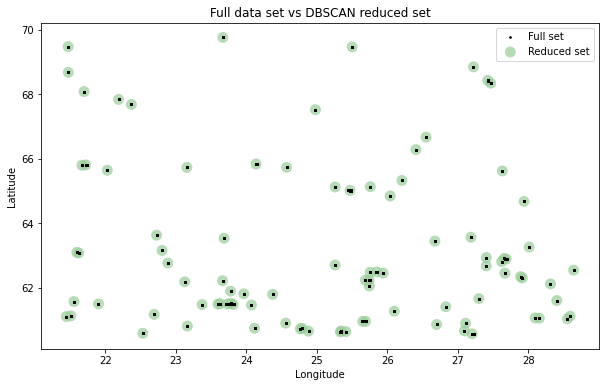

In [73]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()